In [19]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

orig_SR = 44100
orig_blocksize = int(orig_SR * 1)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize, overlap, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize, overlap, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return items

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2346.33 MiB, increment: 2042.77 MiB
CPU times: user 4min, sys: 1.93 s, total: 4min 2s
Wall time: 4min 3s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1731.16 MiB, increment: 223.15 MiB
CPU times: user 57.6 s, sys: 572 ms, total: 58.1 s
Wall time: 58.5 s


## Estimator

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 50
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=orig_SR,
        n_mels=128,
        input_shape=(1, orig_blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
%%time

clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

%memit history = clas.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 165, 32)      2624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 9, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                36896     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

ValueError: Error when checking input: expected melspectrogram_2_input to have shape (1, 44100) but got array with shape (1, 16000)

In [16]:
%%time

pred = clas.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

ValueError: Error when checking input: expected melspectrogram_1_input to have shape (1, 80000) but got array with shape (1, 16000)

## Full Evaluation
We combine the classifiers to determine overall performance

In [16]:
%%time

import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = load_file_blockwise(dataset.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = dataset.iloc[data_iloc].h_category
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clas.predict(x_file, verbose=0)
    pred_probs.append(clas.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
   
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))


	File Time: 0.20100617408752441
	File Time: 0.2594585418701172
	File Time: 0.22747159004211426
	File Time: 0.22125530242919922
	File Time: 0.23064827919006348
	File Time: 0.2520475387573242
	File Time: 0.21730399131774902
	File Time: 0.20940136909484863
	File Time: 0.22111988067626953
	File Time: 0.3602278232574463
	File Time: 0.31060194969177246
	File Time: 0.2694110870361328
	File Time: 0.2337501049041748
	File Time: 0.23929548263549805
	File Time: 0.22841548919677734
	File Time: 0.22562146186828613
	File Time: 0.24666714668273926
	File Time: 0.2663991451263428
	File Time: 0.2308826446533203
	File Time: 0.22187423706054688
	File Time: 0.21307730674743652
	File Time: 0.21147966384887695
	File Time: 0.305988073348999
	File Time: 0.2650947570800781
	File Time: 0.3348710536956787
	File Time: 0.3337588310241699
	File Time: 0.22295856475830078
	File Time: 0.23874187469482422
	File Time: 0.20775246620178223
	File Time: 0.20261716842651367
	File Time: 0.20039105415344238
	File Time: 0.207847

	File Time: 0.23496079444885254
	File Time: 0.23531317710876465
	File Time: 0.24736833572387695
	File Time: 0.22705364227294922
	File Time: 0.24394488334655762
	File Time: 0.22498464584350586
	File Time: 0.21997475624084473
	File Time: 0.22077345848083496
	File Time: 0.29613757133483887
	File Time: 0.24723529815673828
	File Time: 0.19419145584106445
	File Time: 0.2041928768157959
	File Time: 0.19633889198303223
	File Time: 0.2030632495880127
	File Time: 0.19533395767211914
	File Time: 0.19756460189819336
	File Time: 0.19124746322631836
	File Time: 0.24925565719604492
	File Time: 0.19912147521972656
	File Time: 0.2016277313232422
	File Time: 0.19672918319702148
	File Time: 0.19837141036987305
	File Time: 0.2106642723083496
	File Time: 0.21646642684936523
	File Time: 0.2563495635986328
	File Time: 0.32555580139160156
	File Time: 0.33512043952941895
	File Time: 0.24035382270812988
	File Time: 0.2645833492279053
	File Time: 0.2289128303527832
	File Time: 0.22493553161621094
	File Time: 0.2

	File Time: 1.0188462734222412
	File Time: 0.9364748001098633
	File Time: 0.8579509258270264
	File Time: 0.5922544002532959
	File Time: 0.44713640213012695
	File Time: 0.45098114013671875
	File Time: 0.32609105110168457
	File Time: 0.398085355758667
	File Time: 0.2664651870727539
	File Time: 0.3385028839111328
	File Time: 0.2607614994049072
	File Time: 0.21204924583435059
	File Time: 0.24390220642089844
	File Time: 0.26533055305480957
	File Time: 0.20974946022033691
	File Time: 0.1965806484222412
	File Time: 0.25626683235168457
	File Time: 0.22667407989501953
	File Time: 0.3113071918487549
	File Time: 0.19760608673095703
	File Time: 0.220383882522583
	File Time: 0.33940625190734863
	File Time: 0.23185181617736816
	File Time: 0.37830567359924316
	File Time: 0.25946950912475586
	File Time: 0.22191238403320312
	File Time: 0.2248547077178955
	File Time: 0.20891427993774414
	File Time: 0.2486884593963623
	File Time: 0.22853636741638184
	File Time: 0.21252679824829102
	File Time: 0.316504240

	File Time: 0.24926185607910156
	File Time: 0.3010425567626953
	File Time: 0.3067491054534912
	File Time: 0.25434303283691406
	File Time: 0.24564790725708008
	File Time: 0.25158262252807617
	File Time: 0.21626543998718262
	File Time: 0.2409675121307373
	File Time: 0.22113966941833496
	File Time: 0.211594820022583
	File Time: 0.1961662769317627
	File Time: 0.21305513381958008
	File Time: 0.22031807899475098
	File Time: 0.21264934539794922
	File Time: 0.2324540615081787
	File Time: 0.255265474319458
	File Time: 0.21133971214294434
	File Time: 0.25200343132019043
	File Time: 0.4127209186553955
	File Time: 0.2398970127105713
	File Time: 0.23537850379943848
	File Time: 0.21425175666809082
	File Time: 0.2131025791168213
	File Time: 0.19912052154541016
	File Time: 0.19153213500976562
	File Time: 0.19833660125732422
	File Time: 0.20602154731750488
	File Time: 0.26556921005249023
	File Time: 0.21906685829162598
	File Time: 0.21972131729125977
	File Time: 0.23239755630493164
	File Time: 0.238138

	File Time: 1.5681016445159912
	File Time: 1.8110058307647705
	File Time: 1.742516040802002
	File Time: 1.6280391216278076
	File Time: 1.496248722076416
	File Time: 1.7008812427520752
	File Time: 2.05417537689209
	File Time: 1.4250953197479248
	File Time: 1.3467068672180176
	File Time: 2.0430450439453125
	File Time: 1.966317892074585
	File Time: 1.886646032333374
	File Time: 1.8195154666900635
	File Time: 1.5753824710845947
	File Time: 1.7795641422271729
	File Time: 1.3696537017822266
	File Time: 2.066246747970581
	File Time: 2.2459557056427
	File Time: 1.9775652885437012
	File Time: 1.5023255348205566
	File Time: 1.6500000953674316
	File Time: 1.7303869724273682
	File Time: 1.6744697093963623
	File Time: 1.5948219299316406
	File Time: 1.7276411056518555
	File Time: 1.363950252532959
	File Time: 1.6404809951782227
	File Time: 1.147284984588623
	File Time: 1.5541372299194336
	File Time: 1.8223507404327393
	File Time: 1.559992790222168
	File Time: 1.1862990856170654
	File Time: 1.1236426

	File Time: 0.3958253860473633
	File Time: 0.25833725929260254
	File Time: 0.23797988891601562
	File Time: 0.23083138465881348
	File Time: 0.27916669845581055
	File Time: 0.2490367889404297
	File Time: 0.2104175090789795
	File Time: 0.2557802200317383
	File Time: 0.21325469017028809
	File Time: 0.2591533660888672
	File Time: 0.2412703037261963
	File Time: 0.21088123321533203
	File Time: 0.22529101371765137
	File Time: 0.202805757522583
	File Time: 0.2079319953918457
	File Time: 0.19310617446899414
	File Time: 0.20721125602722168
	File Time: 0.30509281158447266
	File Time: 0.2392716407775879
	File Time: 0.22730159759521484
	File Time: 0.23225831985473633
	File Time: 0.2394871711730957
	File Time: 0.25671839714050293
	File Time: 0.26002931594848633
	File Time: 0.24549269676208496
	File Time: 0.31438112258911133
	File Time: 0.32819199562072754
	File Time: 0.24806666374206543
	File Time: 0.26215267181396484
	File Time: 0.3011934757232666
	File Time: 0.25643444061279297
	File Time: 0.389278

	File Time: 0.24840021133422852
	File Time: 0.23968148231506348
	File Time: 0.2305307388305664
	File Time: 0.22825884819030762
	File Time: 0.23826026916503906
	File Time: 0.47054338455200195
	File Time: 0.2789900302886963
	File Time: 0.2713782787322998
	File Time: 0.24223732948303223
	File Time: 0.23639893531799316
	File Time: 0.19732403755187988
	File Time: 0.23932170867919922
	File Time: 0.2691323757171631
	File Time: 0.23502016067504883
	File Time: 0.22741103172302246
	File Time: 0.24449992179870605
	File Time: 0.25531435012817383
	File Time: 0.268064022064209
	File Time: 0.2419722080230713
	File Time: 0.3072235584259033
	File Time: 0.3729898929595947
	File Time: 0.2593514919281006
	File Time: 0.22738194465637207
	File Time: 0.25163769721984863
	File Time: 0.2308666706085205
	File Time: 0.22002005577087402
	File Time: 0.21710562705993652
	File Time: 0.24219632148742676
	File Time: 0.2616310119628906
	File Time: 0.25335264205932617
	File Time: 0.24218511581420898
	File Time: 0.295271

	File Time: 0.29914426803588867
	File Time: 0.36025094985961914
	File Time: 0.2347278594970703
	File Time: 0.21921825408935547
	File Time: 0.3126366138458252
	File Time: 0.2866685390472412
	File Time: 0.33170080184936523
	File Time: 0.3058335781097412
	File Time: 0.20535683631896973
	File Time: 0.20894622802734375
	File Time: 0.2538423538208008
	File Time: 0.22143077850341797
	File Time: 0.2149796485900879
	File Time: 0.23718905448913574
	File Time: 0.25199389457702637
	File Time: 0.25614333152770996
	File Time: 0.2447645664215088
	File Time: 0.24081158638000488
	File Time: 0.2622561454772949
	File Time: 0.25150322914123535
	File Time: 0.36086034774780273
	File Time: 0.31500983238220215
	File Time: 0.2389204502105713
	File Time: 0.20911765098571777
	File Time: 0.26589393615722656
	File Time: 0.25358104705810547
	File Time: 0.23170113563537598
	File Time: 0.24170589447021484
	File Time: 0.2491292953491211
	File Time: 0.23742365837097168
	File Time: 0.25116825103759766
	File Time: 0.2598

In [17]:
import numpy as np
targs = np.vstack(full_targets)

0.457
0.4690552092423731
Confusion matrix, without normalization
[[28  1  0 ...  0  0  0]
 [ 0 37  0 ...  0  0  0]
 [ 0  0 15 ...  1  0  9]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  1  1 10]]


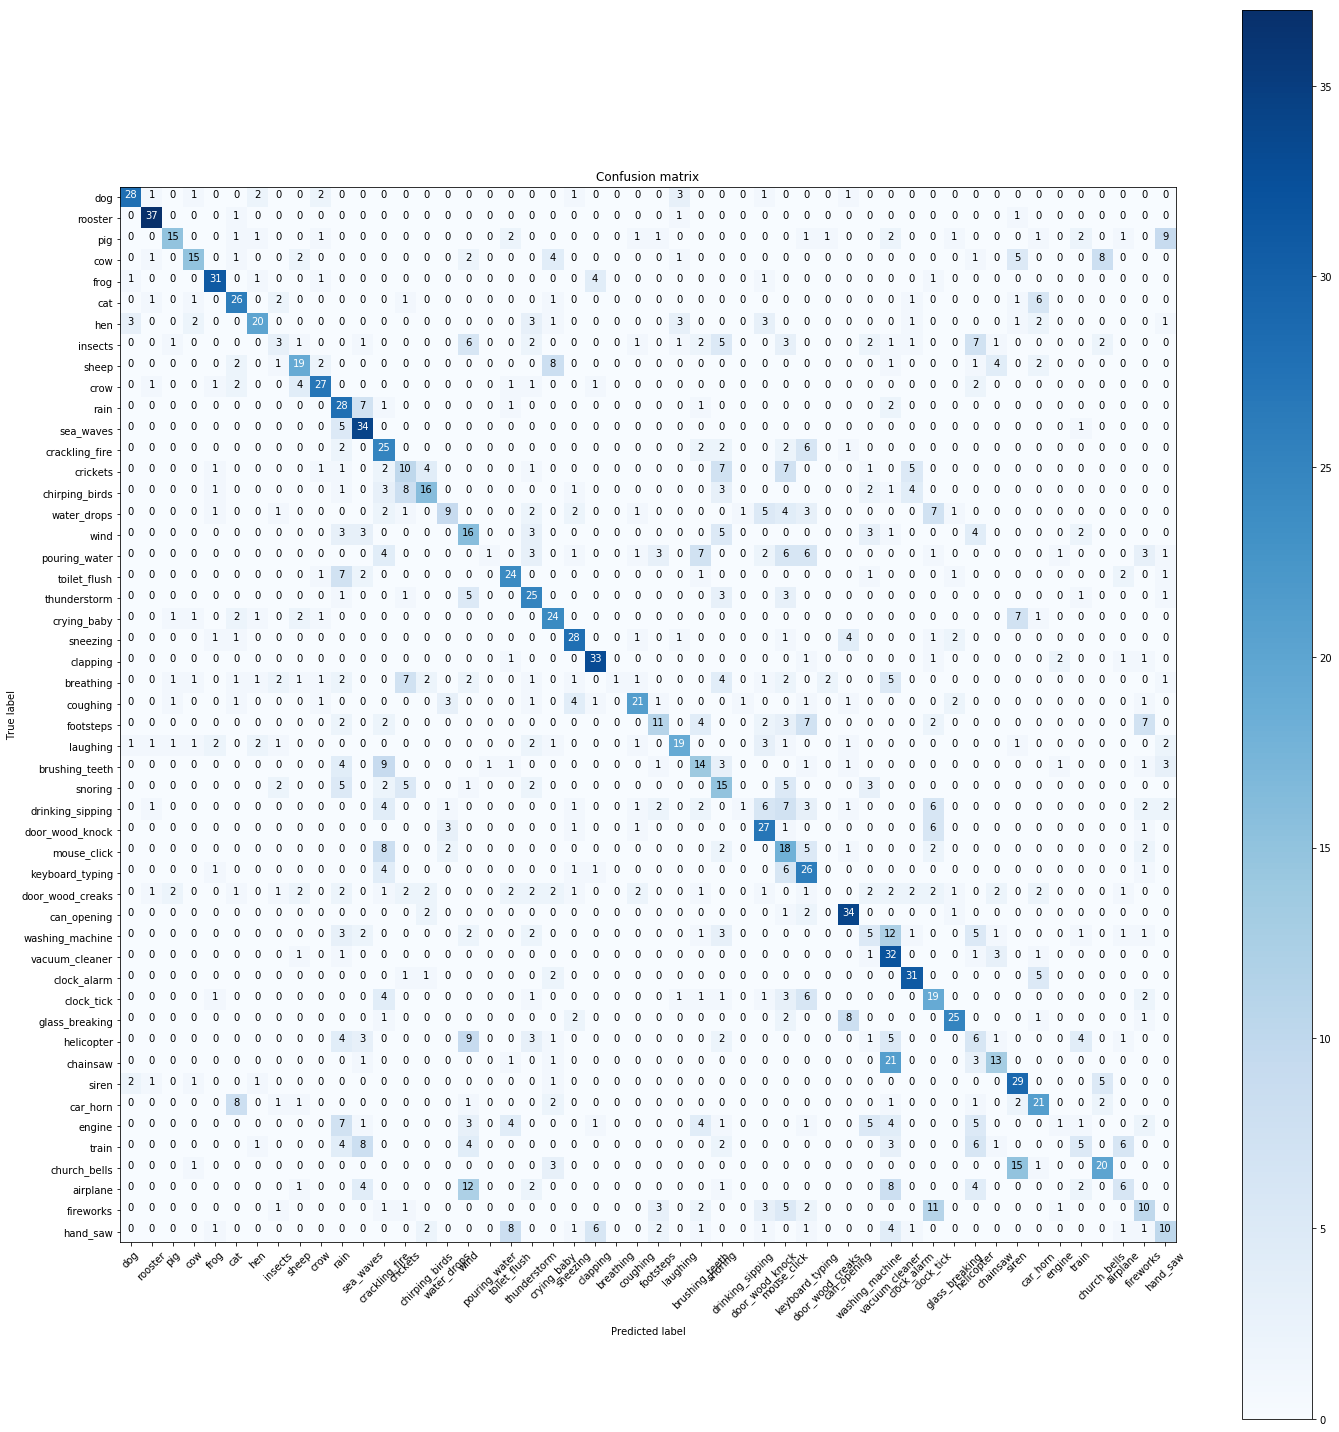

In [18]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [20]:
%%time
from sklearn.model_selection import cross_validate

clf = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

scores = cross_validate(clf, train_X, train_yy, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 165, 32)      2624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 9, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                36896     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
__________

ValueError: Error when checking input: expected melspectrogram_3_input to have shape (1, 44100) but got array with shape (1, 16000)

In [21]:
clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 165, 32)      2624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 9, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                36896     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
__________

ValueError: Error when checking input: expected melspectrogram_4_input to have shape (1, 44100) but got array with shape (1, 16000)

In [22]:
pd.DataFrame(scores)

NameError: name 'scores' is not defined

In [23]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    test = dataset[dataset.fold == 1]
    
    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)

        prob = clf.predict_proba(x_file)[0,l_l]
        pred = clf.predict(x_file)
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [ ]:
%%time
preds = query_dataset('dog')

CPU times: user 4min, sys: 1min 9s, total: 5min 10s
Wall time: 1min 35s


In [ ]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [ ]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.4

In [ ]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

0.4
0.5
0.2
0.1
0.4
0.0
0.2
0.6
0.7
0.6
0.4
0.1
0.3
0.1
0.1
0.1
0.3
0.4
0.2
0.4
0.7
0.0
0.2
0.2
0.3
0.2
0.0
